## 目标检测数据集

- 每行表示一个物体实例
  - 图片文件名，物体类别，边缘框
- [COCO](cocodataset.org)
  - 80类物体，330K图片，1.5M个物体实例

没有特别小的数据集，所以采用d2l标记好的香蕉检测数据集：

In [2]:
%matplotlib inline
import os
import pandas as pd
import torch
import torchvision
import sys
sys.path.append('..')
import utils
import d2l
from matplotlib import pyplot as plt
from torch.utils.data import DataLoader, Dataset

下载数据集：在`../data`目录下，执行`wget d2l-data.s3-accelerate.amazonaws.com/banana-detection.zip`和`unzip banana-detection.zip`

In [11]:
class BananasDataset(Dataset):
    """
    一个用于加载香蕉检测数据集的自定义数据集

    Parameters:
    - root: 存放banana-detection/...的根目录
    - is_train: 是否为训练过程
    """
    def __init__(self, root, is_train=True):
        self.features, self.labels = self.read_data_bananas(root, is_train)
        print('read ' + str(len(self.features)) + (f' training examples' if
              is_train else f' validation examples'))

    def __getitem__(self, idx):
        return (self.features[idx].float(), self.labels[idx])

    def __len__(self):
        return len(self.features)

    def read_data_bananas(self, root, is_train):
        """
        读取香蕉检测数据集中的图像和标签
        """
        data_dir = os.path.join(root, 'banana-detection', 'bananas_train' if is_train
                             else 'bananas_val')
        csv_fname = os.path.join(data_dir, 'label.csv')
        csv_data = pd.read_csv(csv_fname)
        csv_data = csv_data.set_index('img_name')           # 设置key
        images, targets = [], []
        for img_name, target in csv_data.iterrows():        # 以key, value的形式，遍历二维表
            images.append(torchvision.io.read_image(        # 将图片都读取到了内存中
                os.path.join(data_dir, 'images', f'{img_name}')))
            # 这里的target包含（类别，左上角x，左上角y，右下角x，右下角y），
            # 其中所有图像都具有相同的香蕉类（索引为0）
            targets.append(list(target))
        # 对于边界框与类别信息在第2个维度前做了增维处理, 并且进行归一化处理, 图像的尺寸是256x256；因为只有一类图片0，所以不妨碍归一化
        # labels.shape: torch.Size([1000, 1, 5])
        return images, torch.tensor(targets).unsqueeze(1) / 256

torchvision.io.read_image()读取出的图片格式，形如：（通道c，高y，宽x）

实际上这并不是主流的标号表示方式，实际主流可以见kitti数据集（url=my_github）

In [6]:
def load_data_bananas(root, batch_size):
    """
    加载香蕉检测数据集
    
    Parameters:
    - root: 存放banana-detection/...的根目录
    - batch_size: 批量大小
    """
    train_iter = torch.utils.data.DataLoader(BananasDataset(root, is_train=True),
                                             batch_size, shuffle=True)
    val_iter = torch.utils.data.DataLoader(BananasDataset(root, is_train=False),
                                           batch_size)
    return train_iter, val_iter

读取一个小批量，打印其中的图像和标签的形状；edge_size为图片的大小；

In [15]:
batch_size, edge_size = 32, 256
train_iter, _ = load_data_bananas('../data', batch_size)
batch = next(iter(train_iter))
print(batch[0].shape, batch[1].shape)
print(batch[1][0:5])

read 1000 training examples
read 100 validation examples
torch.Size([32, 3, 256, 256]) torch.Size([32, 1, 5])
tensor([[[0.0000, 0.4805, 0.1797, 0.6914, 0.4336]],

        [[0.0000, 0.3438, 0.0312, 0.4883, 0.1875]],

        [[0.0000, 0.5664, 0.0469, 0.7734, 0.2383]],

        [[0.0000, 0.0586, 0.6328, 0.2227, 0.7773]],

        [[0.0000, 0.4062, 0.6914, 0.6055, 0.8828]]])


演示：展示10幅带有真实边界框的图像。

In [18]:
def show_bboxes(ax, bboxes, colors):
    '''
    添加颜色为colors的bboxes到坐标轴ax；

    bboxes和colors的格式暂定为list
    '''
    assert len(bboxes)==len(colors)
    for bbox, color in zip(bboxes, colors):
        ax.add_patch(utils.bbox_corner_to_rect(bbox, color))

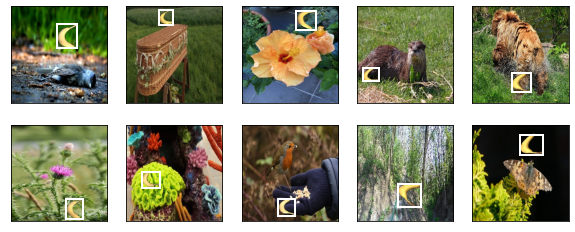

In [19]:
imgs = (batch[0][0:10].permute(0, 2, 3, 1)) / 255
axes = d2l.show_images(imgs, 2, 5, scale=2)
for ax, label in zip(axes, batch[1][0:10]):
    show_bboxes(ax, [label[0][1:5] * edge_size], colors=['w'])          # 前面升维是为了这里label[0]，不知道为啥这么麻烦